In [1]:
import os; import glob
import json; import h5py; import pickle
import numpy as np; import pandas as pd 
import cv2
import matplotlib.pyplot as plt; import matplotlib.image as mpimg; import skimage

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization


%matplotlib inline

Using TensorFlow backend.


## Method I: ConvNet Heatmap

1. Train classifier
2. Create heatmap

Ref: https://github.com/HTuennermann/Vehicle-Detection-and-Tracking/blob/master/LocalizationModel.ipynb

In [2]:
cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars: 
    X.append(skimage.io.imread(name))
X = np.array(X)

# cars are labeled 1, non-cars -1. 
y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

print(y.shape); print(X.shape)

(17760,)
(17760, 64, 64, 3)


In [37]:
# split into train and test. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train = {'features': X_train, 'labels': y_train}
test = {'features': X_test, 'labels': y_test}

# save train and test dictionaries as pickle files. 
with open("./data/train.p", "wb") as f:
    pickle.dump(train, f)
with open("./data/test.p", "wb") as f:
    pickle.dump(test, f)

In [40]:
# dense layers of size N are replaced with conv layers of N filters. 
def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, 
                            border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This replaces Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This replaces Dense(1)
    if filename:
        model.load_weights(filename)
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 64, 64, 3)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 64, 10)    280         lambda_5[0][0]                   
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 64, 64, 10)    910         conv1[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 8, 8, 10)      0           conv2[0][0]                      
___________________________________________________________________________________________

In [41]:
if not os.path.exists("./output"): 
    os.makedirs("./output")

checkpointer = ModelCheckpoint("./output/model_heat.hdf5", verbose=1, save_best_only=True)

# train the classifier
model.fit(X_train, y_train, 
          batch_size=128, nb_epoch=20, verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer])

Train on 14208 samples, validate on 3552 samples
Epoch 1/20
14208/14208 [==============================] - 37s - loss: 0.4517 - acc: 0.5600 - val_loss: 0.2160 - val_acc: 0.8421
Epoch 2/20
14208/14208 [==============================] - 37s - loss: 0.1774 - acc: 0.8725 - val_loss: 0.1288 - val_acc: 0.9167
Epoch 3/20
14208/14208 [==============================] - 37s - loss: 0.1255 - acc: 0.9110 - val_loss: 0.1016 - val_acc: 0.9310
Epoch 4/20
14208/14208 [==============================] - 39s - loss: 0.0884 - acc: 0.9418 - val_loss: 0.0729 - val_acc: 0.9564
Epoch 5/20
14208/14208 [==============================] - 38s - loss: 0.0810 - acc: 0.9507 - val_loss: 0.0703 - val_acc: 0.9589
Epoch 6/20
14208/14208 [==============================] - 37s - loss: 0.0628 - acc: 0.9595 - val_loss: 0.0618 - val_acc: 0.9626
Epoch 7/20
14208/14208 [==============================] - 37s - loss: 0.0530 - acc: 0.9646 - val_loss: 0.0502 - val_acc: 0.9662
Epoch 8/20
14208/14208 [==============================]

In [42]:
# test the classifier
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.023294422722
Test accuracy: 0.985641891892


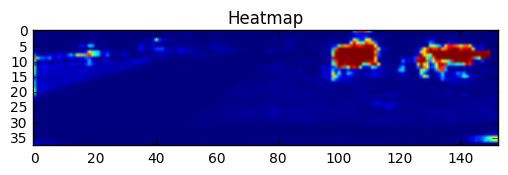

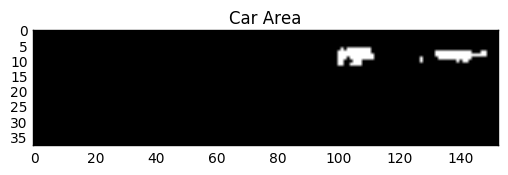

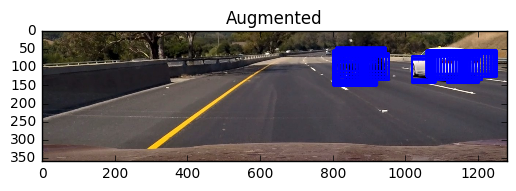

In [61]:
# get the model again. this time, it has no Flatten layer. 
# model output tensor shape (1,1,128) = 128. model input tensor shape (64,64)
model_heat = get_conv(input_shape=(None,None,3), filename="./output/model_heat.hdf5")

def locate(file = "./test_images/test6.jpg"):
    
    data = (skimage.io.imread(file))
    data = data[int(data.shape[0]/2):,:,:] # lower half of the image
    
    heatmap = model_heat.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()
    
    # x, y coordinates of heatmap pixels > 0.99 
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    # pairs of (xmin,ymin) and (xmax, ymax) to draw rectangles
    for i,j in zip(x,y): 
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

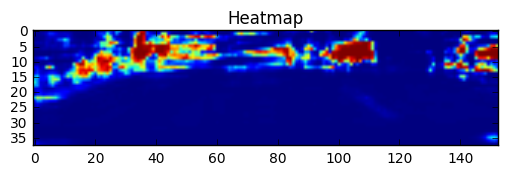

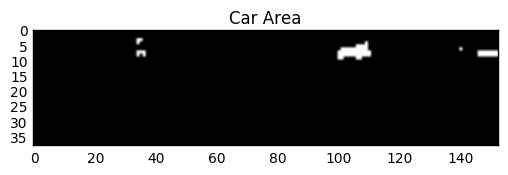

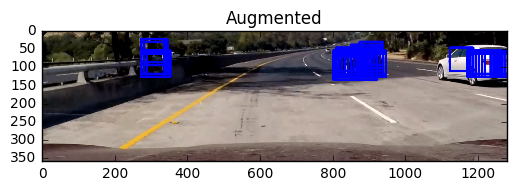

In [62]:
annotated = locate("./test_images/test5.jpg")

plt.title("Augmented")
plt.imshow(annotated)
plt.show()

This method is relatively fast. It's so cool that it works. However, despite the high accuray on test data, there are still many false positives. The solution could be to mix false positives back into training examples and continue to train the model. 

## Method II: U-net

Ref: https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [1]:
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
K.set_image_dim_ordering('tf')
import pandas as pd
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import pickle
from shutil import copyfile

from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

h, w, c = 1200, 1920, 3

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection= K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_unet():

    inputs = Input((h, w, c))
    conv1 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(4, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Using TensorFlow backend.


In [2]:
model = get_unet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1200, 1920, 3) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 1200, 1920, 4) 112         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 1200, 1920, 4) 148         convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 600, 960, 4)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [21]:
# subset dataframe where label is Car
tb = pd.read_csv('./object-detection-crowdai/labels.csv').dropna()
tb_cars = tb[(tb['Label']=='Car')| (tb['Label']=='Truck')].reset_index(drop=True)
tb_cars.head()

xmin  xmax  ymin  ymax                    Frame  Label  \
0   785   533   905   644  1479498371963069978.jpg    Car   
1    89   551   291   680  1479498371963069978.jpg    Car   
2   268   546   383   650  1479498371963069978.jpg    Car   
3   455   522   548   615  1479498371963069978.jpg  Truck   
4   548   522   625   605  1479498371963069978.jpg  Truck   

                                         Preview URL  
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
3  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
4  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

In [22]:
# number of rows that have label "Car"
print(tb_cars.shape)

(66389, 7)


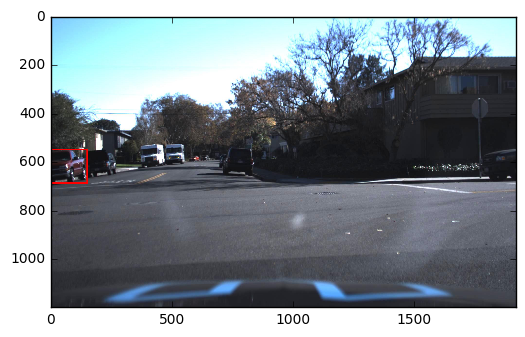

In [23]:
# check if the bounding box coordinates are correct. they aren't. but they work. 
img = mpimg.imread(os.path.join('./object-detection-crowdai', tb_cars['Frame'][10]))
xmin, ymin, xmax, ymax = tb['xmin'][10], tb['xmax'][10], tb['ymin'][10], tb['ymax'][10]
img_ = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
plt.imshow(img_)

In [24]:
# shuffle the dataframe. 
tb_cars = tb_cars.reindex(np.random.permutation(np.arange(tb_cars.shape[0]))).reset_index(drop=True)
tb_cars.head()

xmin  xmax  ymin  ymax                    Frame Label  \
0    32   597   193   645  1479503197294102595.jpg   Car   
1  1068   554  1157   632  1479506050488785019.jpg   Car   
2  1016   539  1067   582  1479503098272819463.jpg   Car   
3   140   577   268   660  1479502414238612913.jpg   Car   
4  1293   519  1379   564  1479499770062555206.jpg   Car   

                                         Preview URL  
0  http://crowdai.com/images/HfXKUrVqWnwmmRvV/vis...  
1  http://crowdai.com/images/4YzUcqEMIIBgWzh8/vis...  
2  http://crowdai.com/images/wJzkwQcmAorwb7LK/vis...  
3  http://crowdai.com/images/_8NeZHDSKAsIfXSC/vis...  
4  http://crowdai.com/images/gpjVION4lGLg9vpi/vis...

In [25]:
# gather bounding boxes information for each image. 
def udf(row):
    return list(zip( list(row['xmin']), list(row['xmax']), list(row['ymin']), list(row['ymax']) ))

tb_cars_ = tb_cars[['xmin','xmax','ymin','ymax','Frame']].groupby('Frame').apply(udf)
tb_cars_.head()

Frame
1479498371963069978.jpg    [(633, 561, 680, 597), (89, 551, 291, 680), (4...
1479498372942264998.jpg    [(368, 528, 468, 624), (684, 570, 723, 628), (...
1479498373462797835.jpg    [(450, 532, 531, 622), (343, 533, 448, 634), (...
1479498373962951201.jpg    [(573, 586, 613, 617), (417, 534, 509, 640), (...
1479498374962942172.jpg    [(404, 577, 547, 710), (1558, 530, 1919, 749),...
dtype: object

In [26]:
# there are 9130 images where cars exist. print an example. 
print(tb_cars_.index[0])
print(tb_cars_.values[0])
print(tb_cars_.shape)

1479498371963069978.jpg
[(633, 561, 680, 597), (89, 551, 291, 680), (455, 522, 548, 615), (758, 557, 807, 617), (785, 533, 905, 644), (1726, 484, 1919, 646), (548, 522, 625, 605), (268, 546, 383, 650), (682, 557, 718, 593)]
(9212,)


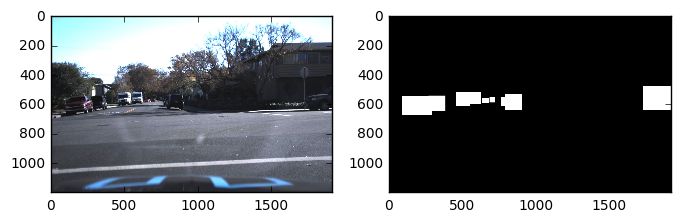

In [27]:
# left: training features example. right: training labels example. 
img = mpimg.imread(os.path.join('./object-detection-crowdai', tb_cars_.index[0]))
masked = np.zeros_like(img)
for p in tb_cars_.values[0]:
    masked[p[1]:p[3], p[0]:p[2], :] = 255
masked = cv2.cvtColor(masked, cv2.COLOR_RGB2GRAY) # 0 to 1
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(1,2,1)
ax = plt.imshow(img)
ax = fig.add_subplot(1,2,2)
ax = plt.imshow(masked, cmap='gray')

In [10]:
# sample a fixed number of examples from the full set of 9130 car images. 
def sample_train_test(series, n = 500):
    
    img_list, mask_list = [], []
    
    tot = len(series.index)
    
    for i in np.random.choice(np.arange(tot), n, replace = False):
        
        img = mpimg.imread(os.path.join('./object-detection-crowdai', series.index[i]))
        
        mask = np.zeros_like(img[:,:,0])
        
        for p in series.values[i]:
            mask[p[1]:p[3], p[0]:p[2]] = 1
        
        mask = np.expand_dims(mask, axis=2) # shape: [1200, 1290, 1], 0 and 1
        img_list.append(img)
        mask_list.append(mask)
    
    img_train, img_test, mask_train, mask_test = train_test_split(img_list, mask_list, test_size=0.1)
    
    train = {'img': np.array(img_train), 'mask': np.array(mask_train)}
    test = {'img': np.array(img_test), 'mask': np.array(mask_test)}
    return train, test

In [11]:
# sampling 10 examples takes 8 seconds. 
t0 = time.time()
train, test = sample_train_test(tb_cars_, n=100)
t1 = time.time()
print(t1-t0)

8.610930919647217


In [12]:
# save 100 examples as pickle files. 
with open("./data/train_cars.p", "wb") as f:
    pickle.dump(train, f, protocol=4)
with open("./data/test_cars.p", "wb") as f:
    pickle.dump(test, f, protocol=4)

In [32]:
# generator function that yields batches of training features and labels. 
def gen_train(dat, batch_size = 16):
    # `dat` is a dictionary consisting of training features and labels. 
    
    # empty batches
    batch_images = np.zeros((batch_size, h, w, 3), dtype=np.uint8)
    batch_masks = np.zeros((batch_size, h, w, 1), dtype=np.uint8)
    
    cursor = 0
    
    while True:
        for i in np.arange(batch_size):
            cursor = cursor % dat['img'].shape[0]
            # update batch features and labels given `dat`
            batch_images[i], batch_masks[i] = dat['img'][cursor], dat['mask'][cursor]
            cursor += 1
        yield (batch_images, batch_masks)

# load train or test data from pickle file. 
def load_data(file = './data/train_cars.p'):
    with open(file, mode = 'rb') as f:
        dat = pickle.load(f)
    return {'img': dat['img'], 'mask': dat['mask']}

train = load_data('./data/train_cars.p')

train_batch = gen_train(train, batch_size = 3)
batch = next(train_batch)

# check if the generator works correctly. 
print((batch[0].shape))

(3, 1200, 1920, 3)


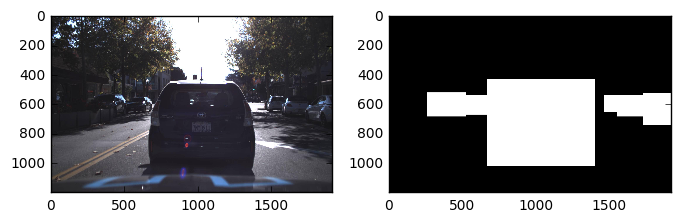

In [33]:
# the generator function works correctly. 
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(1,2,1)
ax = plt.imshow(batch[0][0,])
ax = fig.add_subplot(1,2,2)
ax = plt.imshow(batch[1][0,:,:,-1], cmap='gray')

In [34]:
# plot raw image, model-masked image, true mask
def plot_img_mask(img_arr, mask_arr, pred_arr):
    
    # randomly select an image to plot from the image array. 
    k = np.random.randint(0, img_arr.shape[0])
    
    # raw image, true mask, model-masked image. 
    img = np.array(img_arr[k,], dtype=np.uint8)
    mask = np.array(mask_arr[k,]*255, dtype=np.uint8)
    pred = np.array(pred_arr[k,]*255, dtype=np.uint8)
    
    # use red color channel for masking for model-masked image
    pred = cv2.cvtColor(pred,cv2.COLOR_GRAY2RGB)
    pred[:,:,[1,2]] = 0*pred[:,:,1:2]
    
    # use green color channel for masking for true mask
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    mask[:,:,[0,2]] = 0
    
    # blend true mask and model-masked images with raw image
    pred = cv2.addWeighted(pred, 0.5, img_arr[k,], 1, 0)
    mask = cv2.addWeighted(mask, 0.5, img_arr[k,], 1, 0)
    
    # plot them side by side in one row
    fig = plt.figure(figsize=(16,36))
    ax = fig.add_subplot(1,3,1)
    ax = plt.imshow(img) 
    ax = fig.add_subplot(1,3,2)
    ax = plt.imshow(pred)
    ax = fig.add_subplot(1,3,3)
    ax = plt.imshow(mask)

    return ax

#### Proof of concept

In [ ]:
# 3 examples: 11 sec/epoch
train_batch = gen_train(train, batch_size = 20)
batch = next(train_batch)

model = get_unet()

model_checkpoint = ModelCheckpoint('./output/model_overfit.hdf5', monitor='loss', save_best_only=True)

model.fit(batch[0], batch[1], nb_epoch=10, callbacks=[model_checkpoint])

Epoch 1/10
20/20 [==============================] - 698s - loss: -0.0508 - dice_coef: 0.0508
Epoch 2/10


In [ ]:
pred_arr = model.predict(batch[0])

In [ ]:
# plot a random example from the test image. 
plot_img_mask(batch[0], batch[1], pred_arr)

### Optimization Test: ImageDataGenerator().flow

In [18]:
# ImageDataGenerator().flow works. However, it's memory inefficient. 
# 90 examples in batches of 8 take over 400 seconds to train. 

model = get_unet()
datagen = ImageDataGenerator()

model_checkpoint = ModelCheckpoint('./output/model_unet_temp_flow.hdf5', monitor='loss', save_best_only=True)

model.fit_generator(datagen.flow(train['img'], train['mask'], batch_size=8),
                    samples_per_epoch=train['img'].shape[0], nb_epoch=2,
                    callbacks=[model_checkpoint])

Epoch 1/2
90/90 [==============================] - 412s - loss: -0.1305 - dice_coef: 0.1305     

In [20]:
# use model to predict on test images. 
pred_arr = model.predict(test['img'])

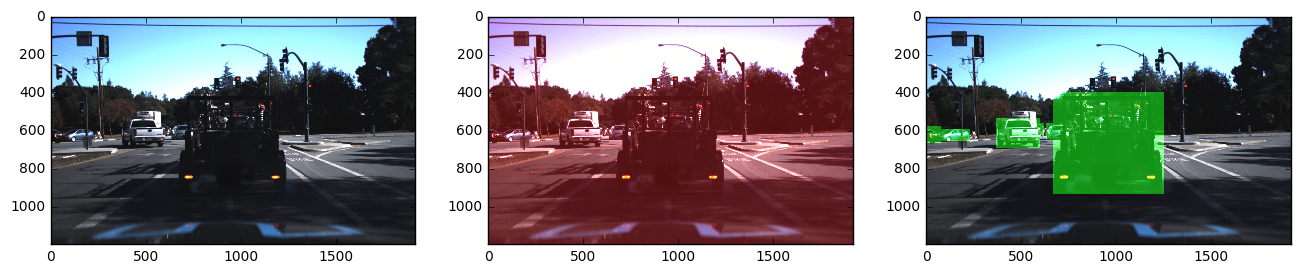

In [21]:
# plot a random example from the test image. 
plot_img_mask(test['img'], test['mask'], pred_arr)

##### Randomly select 1000 car images to train a model on AWS. 

In [29]:
# AVOID RUNNING AGAIN.

# place car and trucks images in ./data/cars/

for i in tb_cars_.index:
    copyfile(os.path.join('./object-detection-crowdai/', i), os.path.join('./data/cars/', i))

In [30]:
# AVOID RUNNING AGAIN.

# select 500 car images for ./data/cars_1000

for i in tb_cars_.index[np.random.choice(np.arange(len(tb_cars_.index)), 500, replace = False)]:
    copyfile(os.path.join('./data/cars/', i), os.path.join('./data/vehicles_500/', i))

### Optimization Test: Custom generator

In [5]:
# assume that tb_cars_ is available. 
# tb_cars_ has car images info and their corresponding bounding boxes.

def get_X_y(jpg):
    '''
    jpg: str of form '1479498371963069978.jpg'
    
    '''
    # X has shape (h, w, 3)
    X = mpimg.imread(os.path.join('./data/cars_1000/', jpg))
    
    # bbox is a list of tuples of size 4. 
    bbox = tb_cars_.values[list(tb_cars_.index).index(jpg)]
    
    # y has shape (h, w, 1)
    y = np.zeros_like(X[:,:,0])
    
    # update y pixels that fall inside bounding boxes. 
    for p in bbox:
        y[p[1]:p[3], p[0]:p[2]] = 1
    
    # makes sure y has shape (h, w, 1)
    y = np.expand_dims(y, axis=2)
    
    return X, y

In [6]:
# custom generator function to generate batch data. 
def gen_batch(listdir, batch_size = 16):
    '''
    listdir: list of image names of form '1479498371963069978.jpg'
    '''
    
    batch_X = np.zeros((batch_size, h, w, 3), dtype=np.uint8)
    batch_y = np.zeros((batch_size, h, w, 1), dtype=np.uint8)
    
    cursor = 0
    
    while True:
        for i in np.arange(batch_size):
            cursor = cursor % len(listdir)
            # call get_X_y to flow in the images given hooks, which are image names here.
            batch_X[i], batch_y[i] = get_X_y(listdir[cursor])
            cursor += 1
        yield (batch_X, batch_y)

In [104]:
# custom generator that yields batches of 10 examples. 
train_batch = gen_batch(os.listdir('./data/cars_1000')[:20], 10)

In [49]:
# 20 examples in batches of 10 take 80 seconds to train. 

model = get_unet()
model_checkpoint = ModelCheckpoint('./output/model_unet_temp_ffd.hdf5', monitor='loss', save_best_only=True)

model.fit_generator(train_batch, nb_epoch=3, verbose=1, samples_per_epoch = 20,
                    callbacks=[model_checkpoint])

Epoch 1/3
20/20 [==============================] - 82s - loss: -0.1222 - dice_coef: 0.1222     
Epoch 2/3
20/20 [==============================] - 77s - loss: -0.1376 - dice_coef: 0.1376     
Epoch 3/3
20/20 [==============================] - 78s - loss: -0.1309 - dice_coef: 0.1309     


In [77]:
# load model weights again. 
model.load_weights('./output/model_unet_temp_ffd.hdf5')

# predict on a batch of images. 
img_arr, mask_arr = next(train_batch)
pred_arr = model.predict(img_arr)

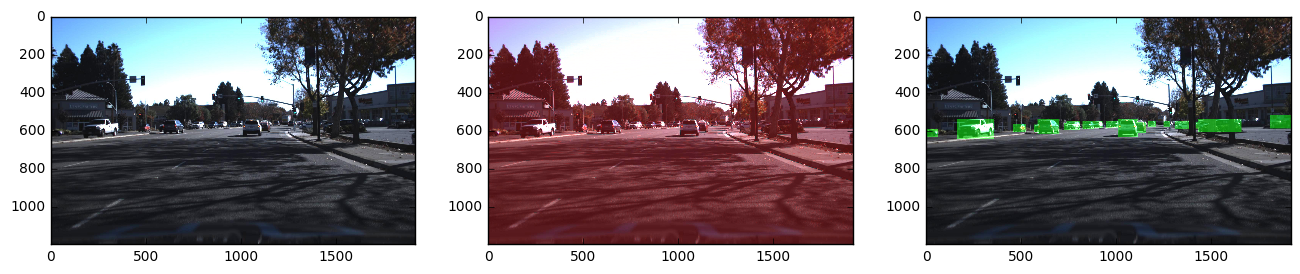

In [79]:
# plot the results. 
plot_img_mask(img_arr, mask_arr, pred_arr)

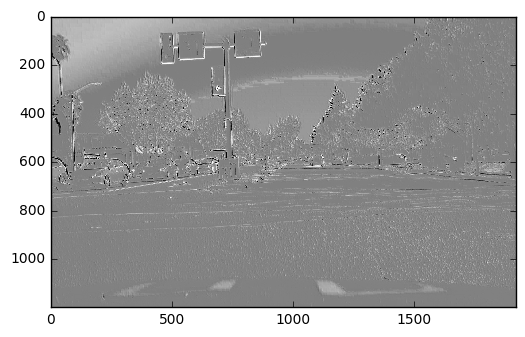

In [80]:
# check to see with a dice_coef of 0.13, how the model performs an image
plt.imshow((pred_arr*255).astype(np.uint8)[0,:, :, -1], cmap='gray')

#### Check to see if weights can be saved as json files. (Yes, they can!)

In [64]:
# save weights as json
model.save_weights("./output/model_unet.json")

In [65]:
# load model and weights in json
model = get_unet()
model.load_weights("./output/model_unet.json")

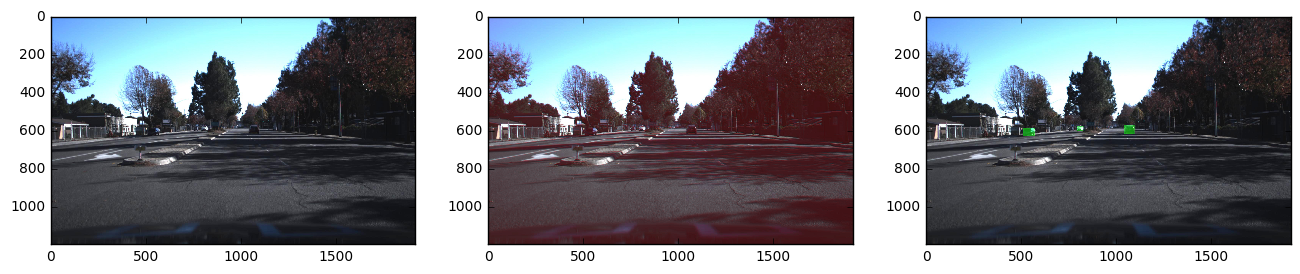

In [66]:
# make predictins and plot them. json works!
pred_arr = model.predict(img_arr)
plot_img_mask(img_arr, mask_arr, pred_arr)

#### Check AWS speed. dice_coef = 0.24 after 3 epochs of 20 examples in batches of 10. training took 5.3 minutes.

In [68]:
# load weights trained on databricks!
model = get_unet()
model.load_weights('./output/model_db.hdf5')

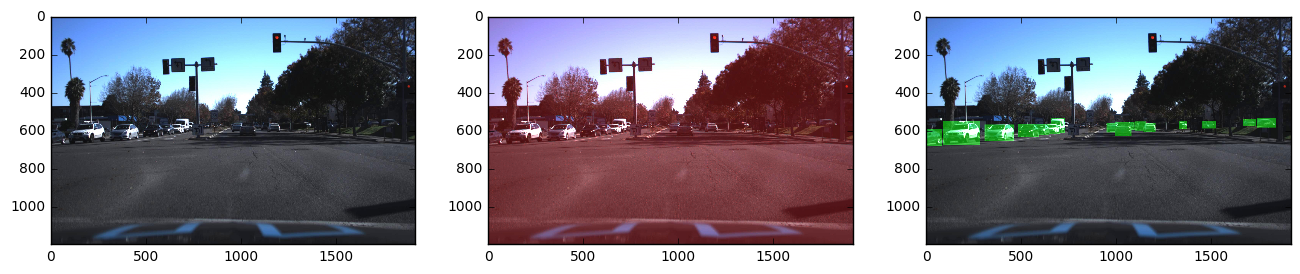

In [69]:
# make predictions and plot. 
pred_arr = model.predict(img_arr)
plot_img_mask(img_arr, mask_arr, pred_arr)

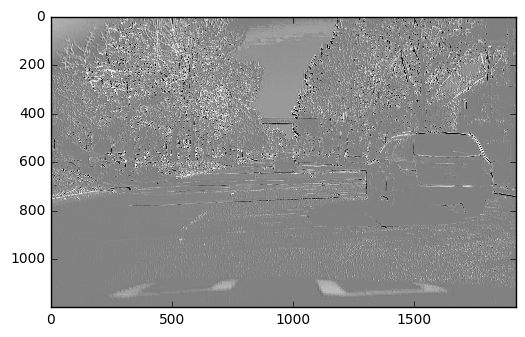

In [81]:
# check if these are better weights. 
plt.imshow((pred_arr*255).astype(np.uint8)[1,:, :, -1], cmap='gray')

#### This model has a dice-coef of 0.4. (But it might have been trained from 5 examples. )

In [52]:
model = get_unet()
model.load_weights('./output/model_unet_temp.hdf5')

In [53]:
pred = model.predict(img_arr)

In [60]:
k = 6

img = test['img'][k,] 
mask_pred = np.array(255*pred[k],dtype=np.uint8) 
mask_pred = cv2.cvtColor(mask_pred,cv2.COLOR_GRAY2RGB)
mask_pred[:,:,1:3] = 0*mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(mask_pred, 0.7, img, 0.3, 0)

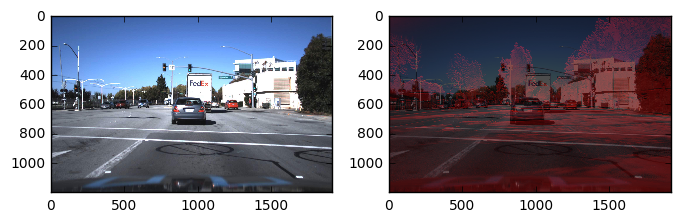

In [61]:
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(1,2,1)
ax = plt.imshow(img) 
ax = fig.add_subplot(1,2,2)
ax = plt.imshow(img_pred)

#### dice_coef = 0.3 after 2 epochs of 1000 examples in batches of 8. training took 3 hours on databricks. 

In [106]:
model = get_unet()
model.load_weights('./output/model_db.hdf5')

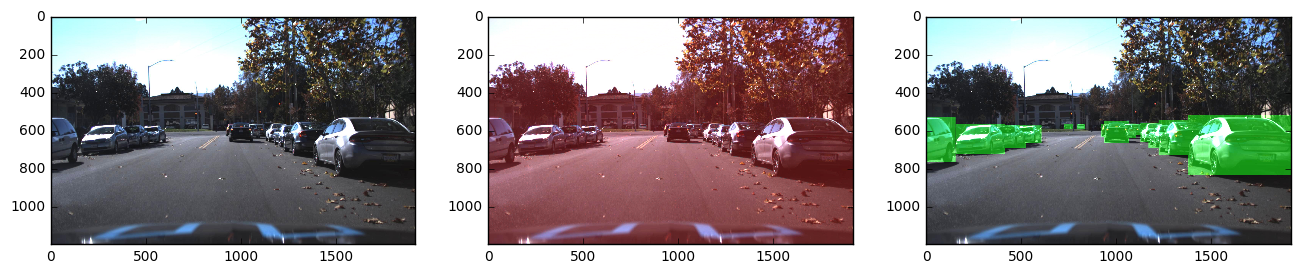

In [107]:
train_batch = gen_batch(os.listdir('./data/cars_1000'), 10)
img_arr, mask_arr = next(train_batch)
pred_arr = model.predict(img_arr)
plot_img_mask(img_arr, mask_arr, pred_arr)

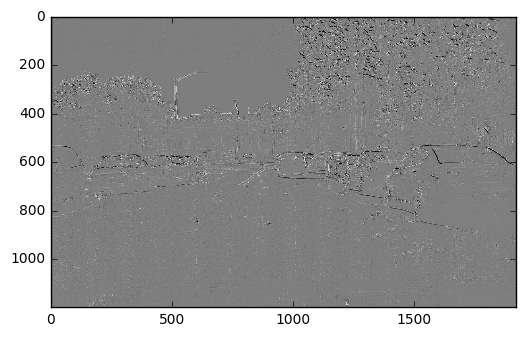

In [108]:
plt.imshow((pred_arr*255).astype(np.uint8)[1,:,:,-1], cmap='gray')

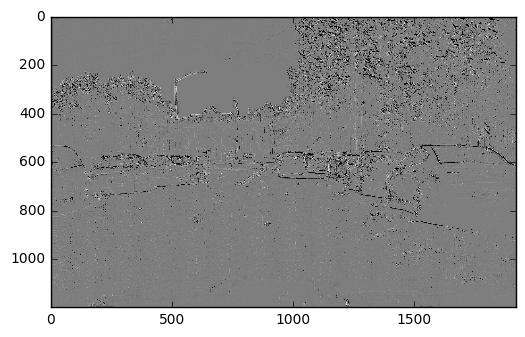

In [125]:
x = (pred_arr*255).astype(np.uint8)
x[x<100]=0
x[x>240]=255
plt.imshow(x[1,:,:,-1], cmap='gray')

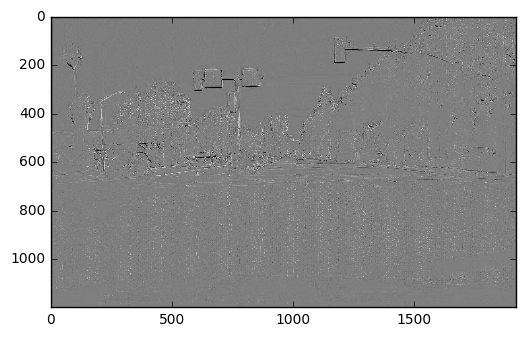

In [110]:
plt.imshow((pred_arr*255).astype(np.uint8)[7,:,:,-1], cmap='gray')

#### dice_coef = 0.42 after 9 epochs of 1000 examples in batches of 8. training took 12 hours on databricks.

In [3]:
model = get_unet()
model.load_weights('./output/model_9epochs.hdf5')

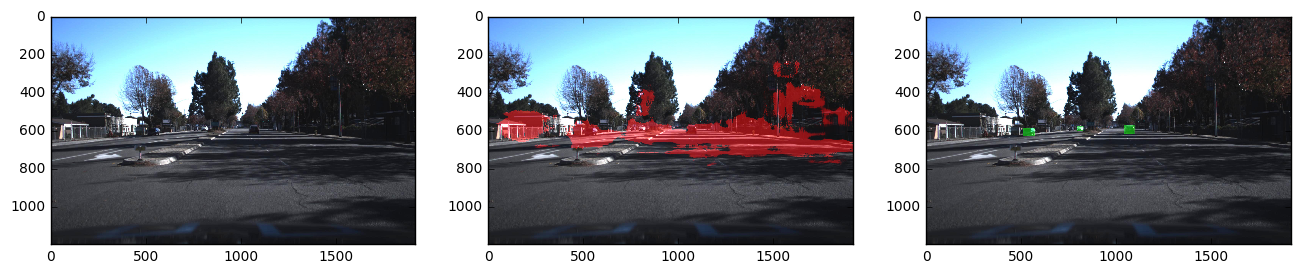

In [127]:
train_batch = gen_batch(os.listdir('./data/cars_1000'), 10)
img_arr, mask_arr = next(train_batch)
pred_arr = model.predict(img_arr)
plot_img_mask(img_arr, mask_arr, pred_arr)

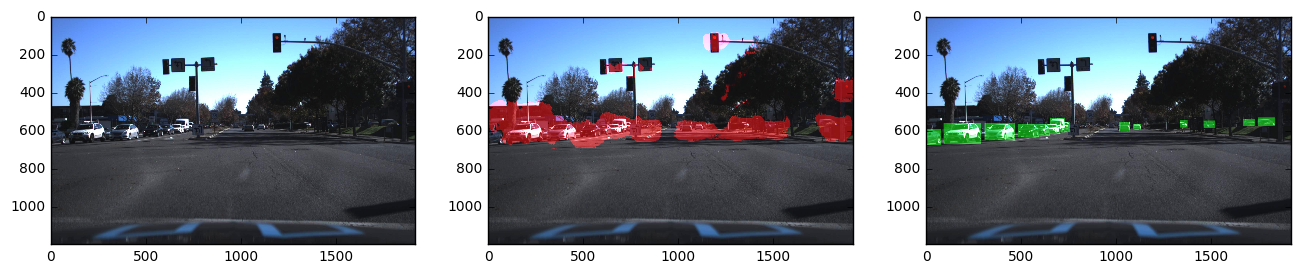

In [128]:
plot_img_mask(img_arr, mask_arr, pred_arr)

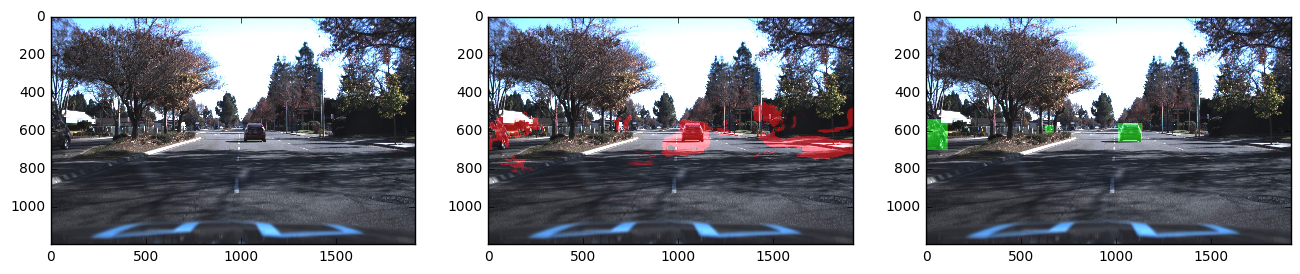

In [129]:
plot_img_mask(img_arr, mask_arr, pred_arr)

In [4]:
model = get_unet()
model.load_weights('./output/model_11epochs.hdf5')

In [11]:
img_arr = mpimg.imread('./test_images/test7.jpeg')
img_arr = img_arr.astype(np.uint8)
img_arr = cv2.resize(img_arr, (1920,1200))
img_arr = np.expand_dims(img_arr, 0)
img_arr.shape

(1, 1200, 1920, 3)

In [12]:
def plot_img_mask(img_arr, pred_arr):
    n = img_arr.shape[0]
    
    fig = plt.figure()
    fig.set_figwidth(8); fig.set_figheight(n*3)
    
    for i in np.arange(n): 
        img = np.array(img_arr[i,], dtype=np.uint8)
        
        ax = fig.add_subplot(n, 2, i*2+1)
        ax = plt.imshow(img)
        
        pred = np.array(pred_arr[i,]*255, dtype=np.uint8)
        pred = cv2.cvtColor(pred,cv2.COLOR_GRAY2RGB)
        pred[:,:,[1,2]] = 0*pred[:,:,1:2]
        pred = cv2.addWeighted(pred, 0.5, img, 1, 0)
        
        ax = fig.add_subplot(n, 2, i*2+2)
        ax = plt.imshow(pred)
        
    return ax

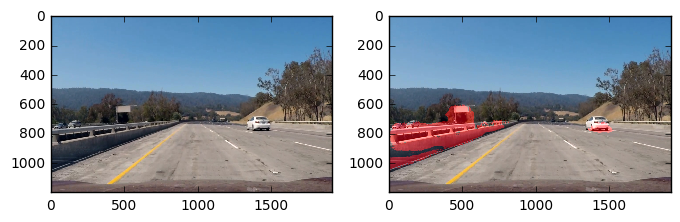

In [14]:
pred_arr = model.predict(img_arr)
plot_img_mask(img_arr, pred_arr)